In [646]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [647]:
# Split data into training/validation and test sets based on dates
train_val_start_date = '2000-01-31'
test_start_date = '2018-08-31'
test_end_date = '2020-08-31'

In [648]:
stock_name = 'XRM'
file_path_1 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv' # Daily technical data (CRSP)

df = pd.read_csv(file_path_1)

df['date'] = pd.to_datetime(df['date'])  # CRSP daily data
df = df[(df['date'] >= train_val_start_date) & (df['date'] <= test_end_date)].copy()
df.index = range(len(df))

df.head()

PERMNO       date TICKER    BIDLO    ASKHI      PRC        VOL        RET  \
0   11850 2000-01-31    XOM  77.8750  83.5625  83.4375  7204601.0   0.057845   
1   11850 2000-02-01    XOM  81.3750  83.4375  83.1875  5332699.0  -0.002996   
2   11850 2000-02-02    XOM  83.2500  84.8750  83.8125  5781399.0   0.007513   
3   11850 2000-02-03    XOM  80.0625  84.0000  82.3750  5805399.0  -0.017151   
4   11850 2000-02-04    XOM  80.0625  83.5000  80.8750  5718099.0  -0.018209   

   OPENPRC  
0  78.6250  
1  83.3125  
2  83.2500  
3  83.4375  
4  83.5000

In [649]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.date,
                      open=df.OPENPRC,
                      high=df.ASKHI,
                      low=df.BIDLO,
                      close=df.PRC,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.date, y=df.VOL, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

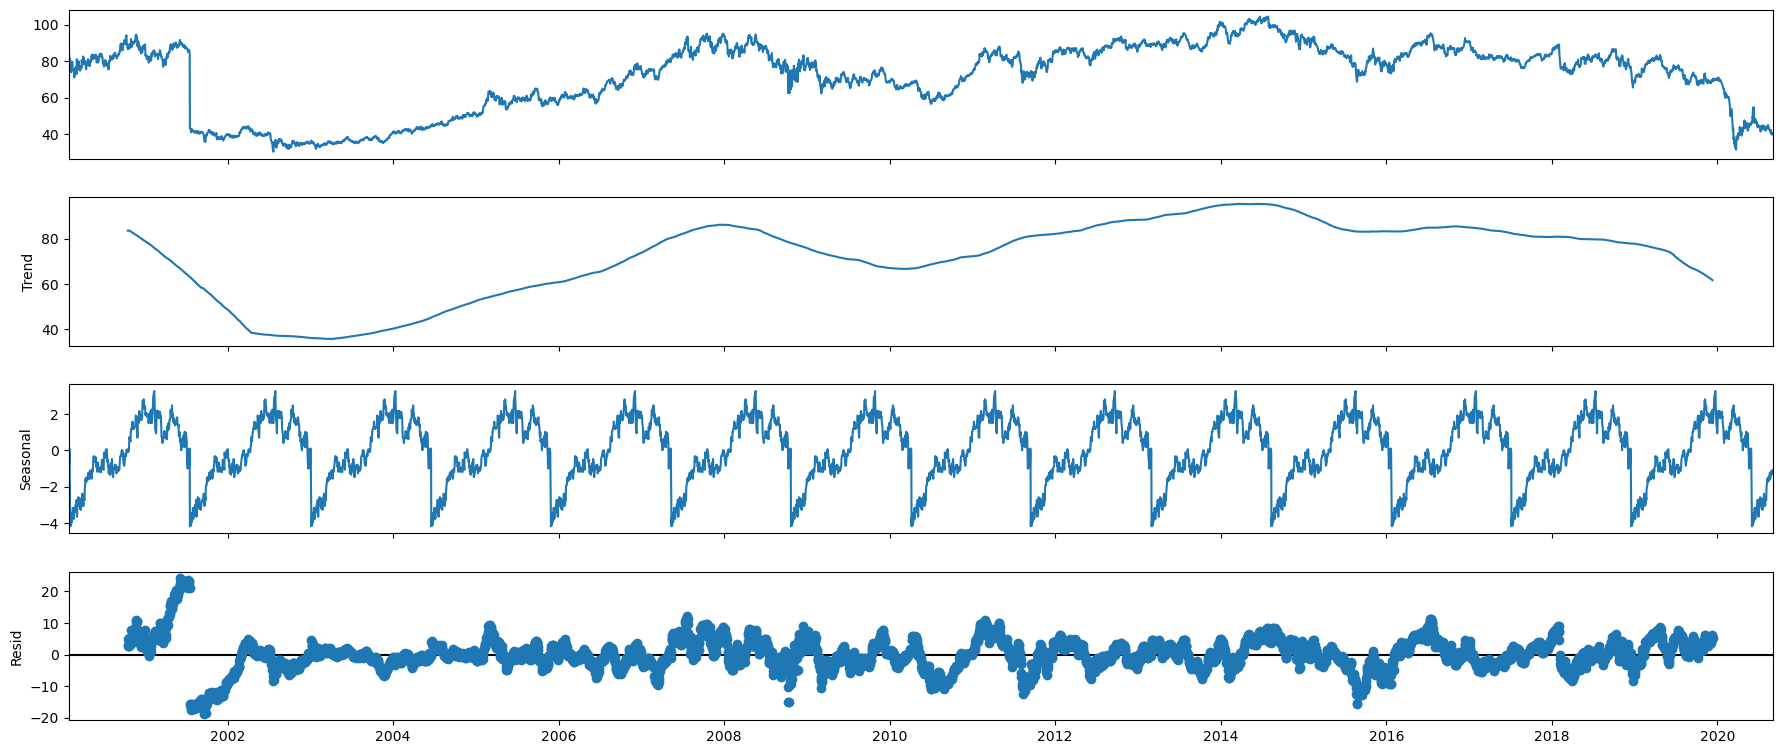

In [650]:
df_close = df[['date', 'PRC']].copy()
df_close = df_close.set_index('date')
df_close.head()

decomp = seasonal_decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

In [651]:
df['EMA_9'] = df['PRC'].ewm(9).mean().shift()
df['SMA_10'] = df['PRC'].rolling(10).mean().shift()
df['SMA_30'] = df['PRC'].rolling(30).mean().shift()
df['SMA_60'] = df['PRC'].rolling(60).mean().shift()
df['SMA_90'] = df['PRC'].rolling(90).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_60, name='SMA 60'))
fig.add_trace(go.Scatter(x=df.date, y=df.SMA_90, name='SMA 90'))
fig.add_trace(go.Scatter(x=df.date, y=df.PRC, name='PRC', opacity=0.2))
fig.show()


In [652]:
def relative_strength_idx(df, n=45):
    close = df['PRC']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.date, y=df.RSI, name='RSI'))
fig.show()

In [653]:
EMA_12 = pd.Series(df['PRC'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['PRC'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.date, y=df.PRC, name='PRC'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [654]:
horizon = 30

df['log_return'] = np.log(df['PRC'].shift(-1*horizon)) - np.log(df['PRC'])  # Compute log returns
df = df.dropna()  # Remove NaNs
df.index = range(len(df))

df.head(10)

PERMNO       date TICKER    BIDLO    ASKHI      PRC        VOL        RET  \
0   11850 2000-06-08    XOM  79.9375  80.6250  80.0625  5336199.0  -0.013097   
1   11850 2000-06-09    XOM  79.1250  80.5625  79.1875  4694000.0  -0.010929   
2   11850 2000-06-12    XOM  79.8750  81.6875  80.7500  5500399.0   0.019732   
3   11850 2000-06-13    XOM  81.0000  82.0000  81.1875  3775899.0   0.005418   
4   11850 2000-06-14    XOM  81.7500  83.7500  82.6250  5526599.0   0.017706   
5   11850 2000-06-15    XOM  81.7500  83.5000  82.4375  5593799.0  -0.002269   
6   11850 2000-06-16    XOM  82.6250  84.3750  83.6875  9784500.0   0.015163   
7   11850 2000-06-19    XOM  82.5000  84.2500  84.0625  4429699.0   0.004481   
8   11850 2000-06-20    XOM  81.7500  83.3750  83.2500  4241799.0  -0.009665   
9   11850 2000-06-21    XOM  81.8125  84.4375  83.9375  4664799.0   0.008258   

   OPENPRC      EMA_9     SMA_10     SMA_30     SMA_60     SMA_90        RSI  \
0  80.1250  81.505209  81.848438  81.120834  79.743750  79.000868  47.775242   
1  80.0000  81.360929  81.560938  81.118750  79.790625  78.963368  49.468399   
2  79.8750  81.143572  81.335938  81.068750  79.814583  78.918924  49.047052   
3  81.2500  81.104213  81.173438  81.170834  79.831250  78.884896  51.601972   
4  81.9375  81.112542  80.942188  81.277084  79.898958  78.871702  54.302398   
5  82.5000  81.263795  80.873438  81.422917  80.028125  78.891146  53.068254   
6  82.6250  81.381170  80.823438  81.597917  80.118750  78.909896  53.705992   
7  83.9375  81.611811  81.273438  81.737500  80.264584  78.962674  53.990179   
8  82.5000  81.856888  81.743750  81.872917  80.407292  79.051563  54.458205   
9  82.0000  81.996204  81.837500  81.966667  80.507292  79.133507  58.806264   

       MACD  MACD_signal  log_return  
0  0.171451     0.528058   -0.038191  
1 -0.014327     0.419581   -0.038621  
2 -0.035162     0.328632   -0.068882  
3 -0.016207     0.259664   -0.067674  
4  0.113429     0.230417   -0.032286  
5  0.198754     0.224085   -0.029233  
6  0.363000     0.251868   -0.045063  
7  0.517445     0.304983   -0.050315  
8  0.567766     0.357540   -0.004515  
9  0.655540     0.417140   -0.030237

In [655]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.date, y=train_df.PRC, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.date, y=valid_df.PRC, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.date,  y=test_df.PRC,  name='Test'))
fig.show()

test_prices = test_df['PRC']

In [656]:
test_df.head()

PERMNO       date TICKER  BIDLO  ASKHI    PRC         VOL        RET  \
4302   11850 2017-07-17    XOM  80.83  81.43  80.86   7914701.0  -0.005167   
4303   11850 2017-07-18    XOM  80.41  81.08  80.60   8046119.0  -0.003215   
4304   11850 2017-07-19    XOM  80.27  80.87  80.85   9393178.0   0.003102   
4305   11850 2017-07-20    XOM  80.75  81.49  80.86   9680965.0   0.000124   
4306   11850 2017-07-21    XOM  80.00  80.84  80.12  12268605.0  -0.009152   

      OPENPRC      EMA_9  SMA_10     SMA_30     SMA_60     SMA_90        RSI  \
4302    81.00  81.085005  80.799  81.332333  81.589000  81.712444  46.092005   
4303    81.02  81.062505  80.812  81.377667  81.586500  81.710556  45.683931   
4304    80.44  81.016254  80.662  81.393667  81.585000  81.698667  45.683931   
4305    80.97  80.999629  80.662  81.381667  81.580667  81.690222  46.219239   
4306    80.65  80.985666  80.736  81.380000  81.566167  81.684000  45.849978   

          MACD  MACD_signal  log_return  
4302 -0.232686    -0.252902   -0.055821  
4303 -0.242473    -0.250816   -0.052862  
4304 -0.227436    -0.246140   -0.060547  
4305 -0.212264    -0.239365   -0.057653  
4306 -0.256990    -0.242890   -0.045320

In [657]:
drop_cols = ['date', 'VOL', 'BIDLO', 'ASKHI', 'RET', 'OPENPRC', 'TICKER', 'PERMNO','PRC']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [658]:
y_train = train_df['log_return'].copy()
X_train = train_df.drop(['log_return',], 1)

y_valid = valid_df['log_return'].copy()
X_valid = valid_df.drop(['log_return',], 1)

y_test  = test_df['log_return'].copy()
X_test  = test_df.drop(['log_return',], 1)

test_df.head()

EMA_9  SMA_10     SMA_30     SMA_60     SMA_90        RSI      MACD  \
4302  81.085005  80.799  81.332333  81.589000  81.712444  46.092005 -0.232686   
4303  81.062505  80.812  81.377667  81.586500  81.710556  45.683931 -0.242473   
4304  81.016254  80.662  81.393667  81.585000  81.698667  45.683931 -0.227436   
4305  80.999629  80.662  81.381667  81.580667  81.690222  46.219239 -0.212264   
4306  80.985666  80.736  81.380000  81.566167  81.684000  45.849978 -0.256990   

      MACD_signal  log_return  
4302    -0.252902   -0.055821  
4303    -0.250816   -0.052862  
4304    -0.246140   -0.060547  
4305    -0.239365   -0.057653  
4306    -0.242890   -0.045320

In [659]:
'''

%%time

parameters = {
    'n_estimators': [300],
    'learning_rate': [0.05],
    'max_depth': [8],
    'gamma': [0.00001],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

'''

"\n\n%%time\n\nparameters = {\n    'n_estimators': [300],\n    'learning_rate': [0.05],\n    'max_depth': [8],\n    'gamma': [0.00001],\n    'random_state': [42]\n}\n\neval_set = [(X_train, y_train), (X_valid, y_valid)]\nmodel = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)\nclf = GridSearchCV(model, parameters)\n\nclf.fit(X_train, y_train)\n\nprint(f'Best params: {clf.best_params_}')\nprint(f'Best validation score = {clf.best_score_}')\n\n"

In [660]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 6.38 s, sys: 351 ms, total: 6.73 s
Wall time: 1.02 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1e-05, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

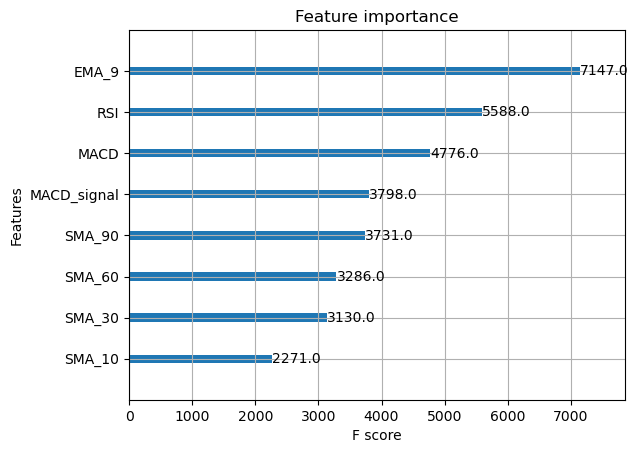

In [661]:
plot_importance(model);

In [662]:
y_pred = model.predict(X_test)

print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

test_df.head()

# Convert predicted log returns to prices
y_pred_price = test_prices.values * np.exp(y_pred)  # Apply transformation
y_test_price = test_prices.values * np.exp(y_test)

print(f'y_true_price = {np.array(y_test_price)[:5]}')
print(f'y_pred_price = {y_pred_price[:5]}')

y_true = [-0.05582076 -0.05286172 -0.06054732 -0.05765322 -0.04532016]
y_pred = [-0.0447766   0.02372287  0.02372287  0.02314363  0.02314363]
y_true_price = [76.47 76.45 76.1  76.33 76.57]
y_pred_price = [77.31922874 82.53492277 82.79092439 82.75321876 81.99589274]


In [663]:
print(f'mean_squared_error = {mean_squared_error(y_test_price, y_pred_price)}')

correct_signs = np.sign(y_test) == np.sign(y_pred)
percentage_correct_signs = np.mean(correct_signs) * 100

print(f"Percentage of Correct Sign Predictions: {percentage_correct_signs:.2f}%")

mean_squared_error = 55.95924761549702
Percentage of Correct Sign Predictions: 52.24%


In [664]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['predPRC'] = y_pred_price
predicted_prices['predPRC'] = predicted_prices['predPRC'].shift(1*horizon)

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.date, y=df.PRC,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.date,
                         y=predicted_prices.predPRC,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.date,
                         y=predicted_prices.PRC,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.date,
                         y=predicted_prices.predPRC,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

predicted_prices.tail()

PERMNO       date TICKER   BIDLO    ASKHI    PRC         VOL        RET  \
5055   11850 2020-07-14    XOM  42.260  44.1900  44.07  21444117.0   0.033052   
5056   11850 2020-07-15    XOM  44.210  45.0886  44.63  17332448.0   0.012707   
5057   11850 2020-07-16    XOM  43.790  44.8100  44.28  14673677.0  -0.007842   
5058   11850 2020-07-17    XOM  43.390  44.6850  43.52  17965089.0  -0.017163   
5059   11850 2020-07-20    XOM  42.475  43.5100  42.50  18553910.0  -0.023438   

      OPENPRC      EMA_9  SMA_10     SMA_30     SMA_60     SMA_90        RSI  \
5055    42.53  44.358996  43.427  46.427333  45.335833  43.312889  47.966069   
5056    45.03  44.330096  43.402  46.353667  45.350000  43.245778  48.932487   
5057    44.31  44.360086  43.393  46.264333  45.407500  43.211778  50.157729   
5058    44.33  44.352078  43.450  46.099000  45.462833  43.238667  51.612903   
5059    43.21  44.268870  43.394  45.913000  45.486000  43.239889  50.200240   

          MACD  MACD_signal  log_return    predPRC  
5055 -0.991005    -0.826552   -0.075138  46.236783  
5056 -0.844950    -0.830232   -0.109277  46.223074  
5057 -0.748811    -0.813947   -0.108175  48.407134  
5058 -0.725581    -0.796274   -0.067238  49.184976  
5059 -0.780480    -0.793115   -0.062126  52.794482